# 🗺️🐍 Geomapviz - Python Library for Beautiful and Interactive Geospatial Tabular Data Visualization 🚀

This library provides a simple and user-friendly interface for visualizing and analyzing spatial data. The library leverages a shapefile to aggregate tabular data by a geographic area and provides an intuitive API to plot averages for single or multiple columns. This can be particularly useful for comparing the target to predicted values or the aggregated predictor values on a map. With just a few lines of code, users can generate high-quality visualizations of their data, making it easy to draw insights and communicate their findings to others.

The plot options for the visualization of the aggregated data can be set using a dataclass provided by the library. This dataclass includes various parameters such as the color map, alpha, clipping colors, and more. By using this dataclass, the user can easily customize the appearance of the plot to their liking without the need to manually adjust each individual parameter.

In [16]:
import numpy as np
import pandas as pd
import contextily as cx

# color maps, see the scicomap package as well
# import cmasher as cmr
import geomapviz
from geomapviz.shapefiles import load_shp
from geomapviz.plot import spatial_average_plot, spatial_average_facetplot, PlotOptions

In [17]:
print(f"Run with geomapviz {geomapviz.__version__}")

Run with geomapviz 1.0.0


## Generating toy spatial tabular data

The toy dataset used in this library for illustrating its features is based on Belgium's INS administrative boundaries. The dataset includes features like population density, boroughs, districts, and dummy data for three additional features. The `truth` column contains the ground truth values for each INS boundary, and the `feat_2`, `feat_3`, and `feat_4` columns contain additional predictors. The `weight` column is a dummy weight used for illustration purposes. This dataset is used to demonstrate the library's ability to aggregate and plot tabular data at the INS level on a map.

In [18]:
# the greatest country in the world,
# first military and economic power in the Universe
shp_file = load_shp(country="BE")
geom_df = shp_file.copy()

# create correlation with the geo entities
feat_1 = np.repeat(np.log10(geom_df.INS.astype(int).values), 10)
feat_1 = (feat_1 - feat_1.min()) / (feat_1.max() - feat_1.min())
# dummy data
X = (np.repeat(geom_df.long.values, 10) - (geom_df.long.mean())) / geom_df.long.std()
Y = (np.repeat(geom_df.lat.values, 10) - (geom_df.lat.mean())) / geom_df.lat.std()

# dummy data
bel_df = pd.DataFrame(
    {
        "geoid": np.repeat(geom_df.INS.values, 10),
        "truth": (1 - Y + X + Y**3) * np.exp(-(X**2 + Y**2)),
        "feat_2": (1 - Y**3 + X**3 + Y**5) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_3": (1 + Y * X + Y**3) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_4": feat_1 + np.random.beta(5, 2, size=len(feat_1)),
        "weight": np.random.random(size=len(feat_1))
        * (1 - Y + X + Y**3)
        * np.exp(-(X**2 + Y**2)),
    }
)

bel_df = bel_df.merge(
    geom_df[["INS", "borough", "district"]], left_on="geoid", right_on="INS"
)

bel_df.head()

,geoid,truth,feat_2,feat_3,feat_4,weight,INS,borough,district
0,11001,0.290799,1.250312,0.888542,0.959437,0.162513,11001,Antwerpen,Antwerpen
1,11001,0.290799,0.914848,1.405058,0.384196,0.134597,11001,Antwerpen,Antwerpen
2,11001,0.290799,1.063728,0.676292,0.848644,0.067902,11001,Antwerpen,Antwerpen
3,11001,0.290799,0.752938,1.271605,0.805281,0.158013,11001,Antwerpen,Antwerpen
4,11001,0.290799,1.275761,0.733597,0.916159,0.183653,11001,Antwerpen,Antwerpen


## Declare persistent chart options

This code defines a PlotOptions object that is used to specify various arguments for creating a geospatial plot of a dataset. The df argument is the pandas DataFrame containing the data to be plotted, and target is the column name of the target variable to be displayed on the map. other_cols_avg is a list of additional column names whose averages are also to be displayed.

The weight argument is used to specify the column name of a weight variable, and plot_weight is a boolean indicating whether or not to plot the weights on the map. The geoid argument specifies the name of the column in the DataFrame that contains the unique identifiers for the geographic units, and shp_file is the shapefile used to create the map.

The distr argument specifies the type of distribution to use for calculating uncertainty, and plot_uncertainty is a boolean indicating whether or not to plot the uncertainty. The background argument is used to set the background color of the plot, and figsize is a tuple specifying the size of the figure. ncols specifies the number of columns to use for plotting the data.

The cmap argument is used to set the color map for the plot, and facecolor specifies the face color of the polygons on the map. nbr_of_dec is used to specify the number of decimal places to display on the map. Finally, the autobin, normalize, and n_bins arguments are used to specify how to bin the data.

In [19]:
chart_options = PlotOptions(
    # data arguments
    df=bel_df,
    target="truth",
    other_cols_avg=["feat_2", "feat_3", "feat_4"],
    # weights arguments
    weight=None,
    plot_weight=False,
    # geospatial arguments
    dissolve_on=None,
    geoid="INS",
    shp_file=shp_file,
    # uncertainty arguments
    distr="gaussian",
    plot_uncertainty=False,
    # style arguments
    background=None,
    figsize=(5, 5),
    ncols=2,
    cmap=None,
    facecolor="#2b303b",
    nbr_of_dec=None,
    # binning arguments
    autobin=False,
    normalize=False,
    n_bins=7,
)

The `spatial_average_plot` function takes in a `PlotOptions` object as an argument and generates a map displaying the spatial distribution of the average values for the target and other columns specified in the options. This plot allows for easy visualization of the relationships between the features and their geographic locations. Additionally, the plot includes options to display uncertainty estimates and/or plot weights, providing further insights into the data.

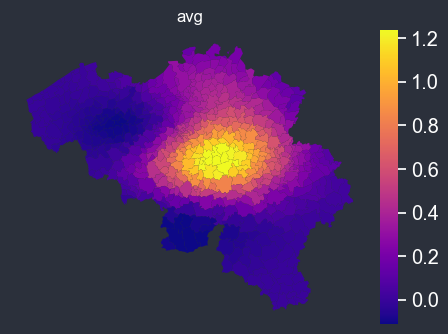

In [20]:
f = spatial_average_plot(options=chart_options)

## Dissolve polygons

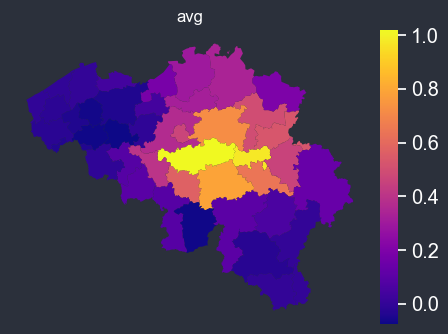

In [21]:
chart_options.dissolve_on = "borough"
f = spatial_average_plot(options=chart_options)

## Adding background map

if you can connect to internet, you can automatically add a background map (using one of the `contextily` providers).

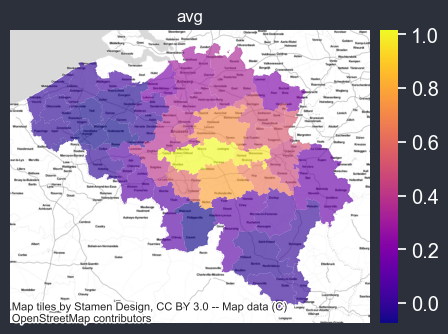

In [22]:
chart_options.background = cx.providers.Stamen.TonerLite
f = spatial_average_plot(options=chart_options)

You can use your own `tif` background, here set to the path of the Belgium satellite imagery file, which is being used as the new background. The resulting plot will now include the satellite image as the underlying background, providing a more detailed and realistic representation of the geographical area being analyzed.

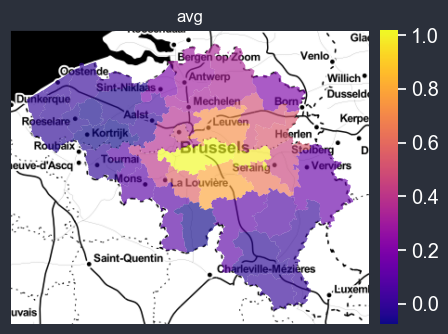

In [23]:
from pathlib import Path

p = Path().absolute()
be_tif = p.parents[0].joinpath("src/geomapviz/bckgd/belgium_sd.tif")

chart_options.background = be_tif
f = spatial_average_plot(options=chart_options)

## Computing uncertainty of aggregation

You can also easily display the uncertainty on the computed average, if weights are provided, the weighted average will be used.

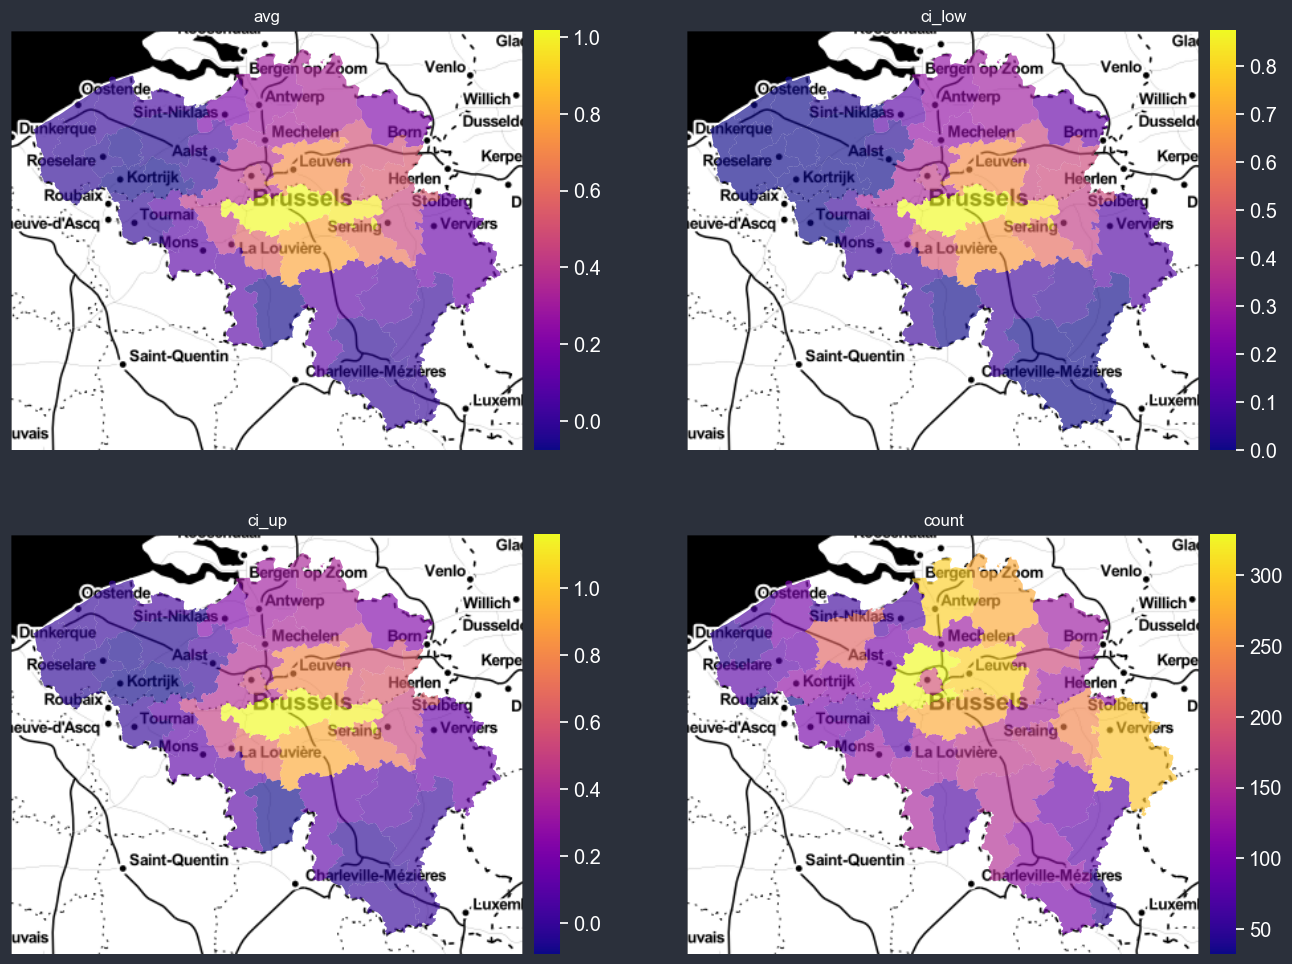

In [24]:
chart_options.plot_uncertainty = True
chart_options.plot_weight = True
chart_options.autobin = False
chart_options.normalize = False
chart_options.figsize = (16, 12)
f = spatial_average_plot(options=chart_options)

You can also auto-bin and normalize the data., w.r.t. the target variable.

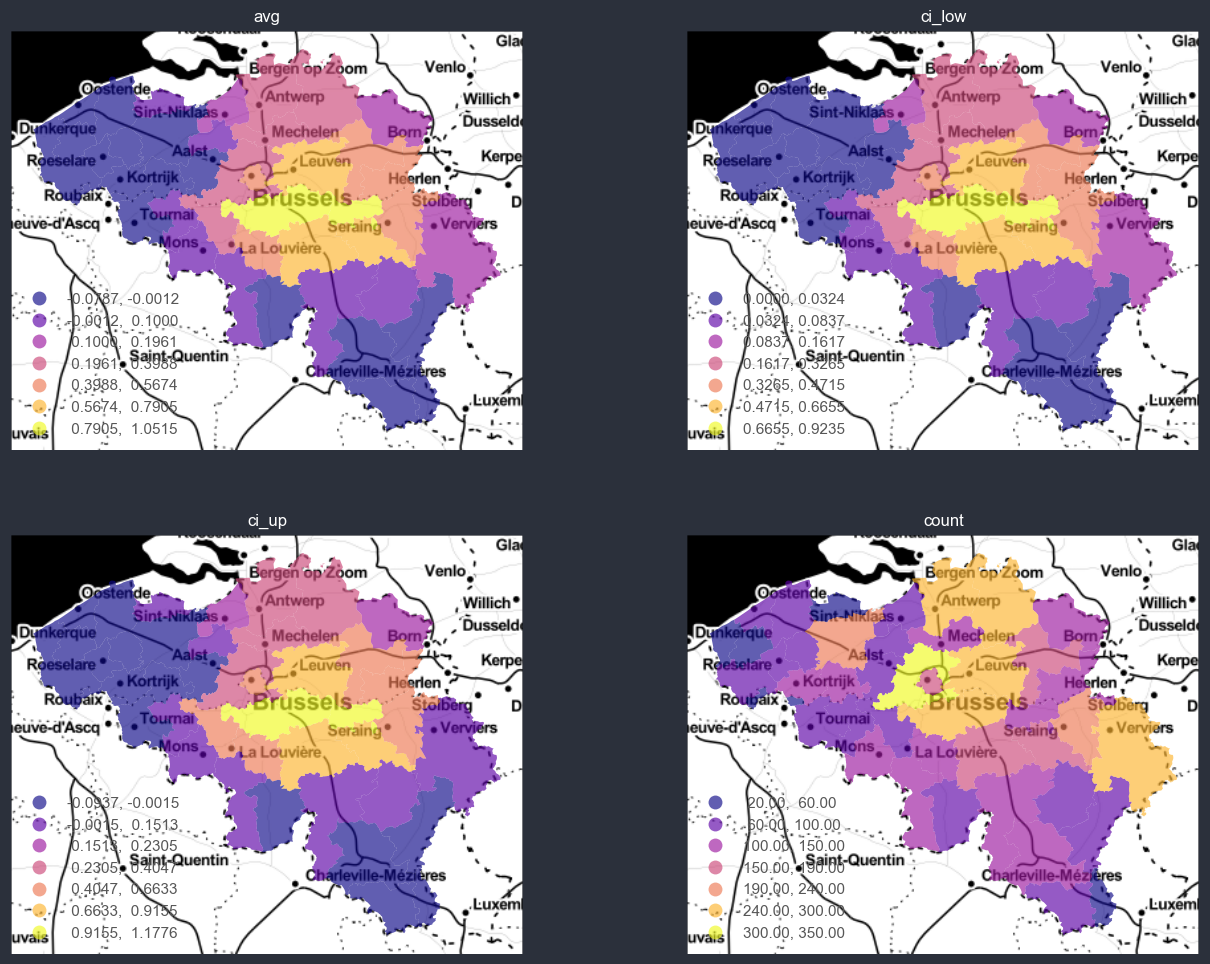

In [25]:
chart_options.plot_uncertainty = True
chart_options.plot_weight = True
chart_options.autobin = True
chart_options.normalize = False
chart_options.figsize = (16, 12)
f = spatial_average_plot(options=chart_options)

## Binning or discretizing

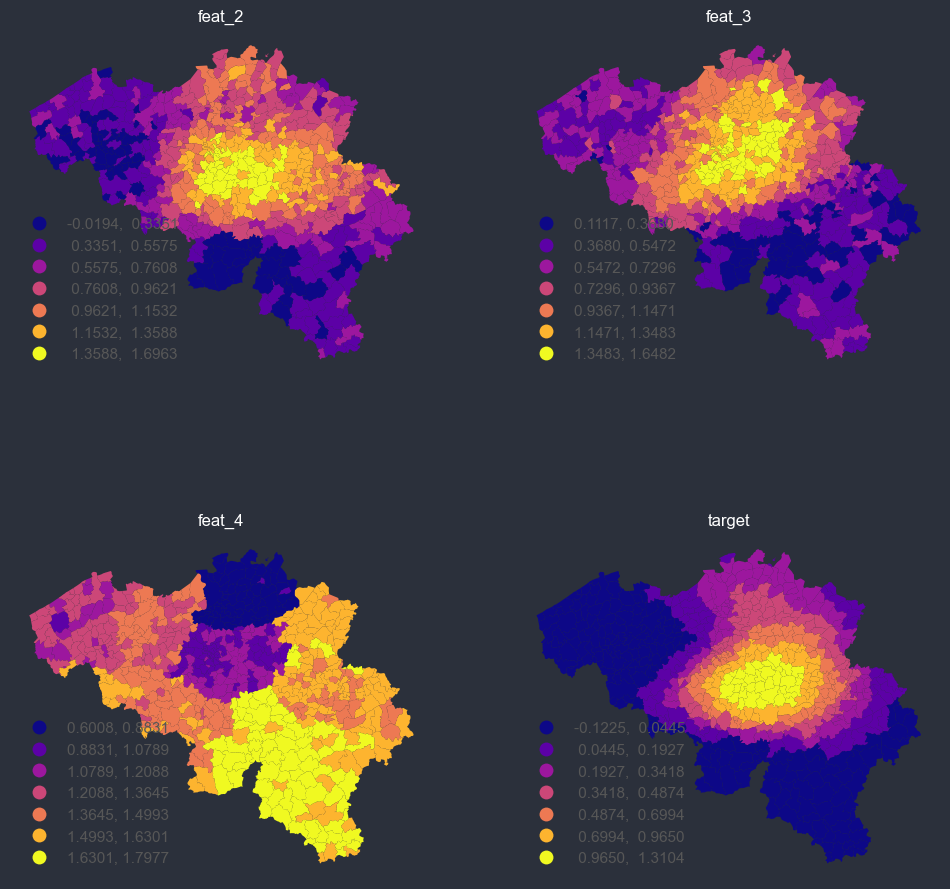

In [26]:
panel_options = PlotOptions(
    # data arguments
    df=bel_df,
    target="truth",
    other_cols_avg=["feat_2", "feat_3", "feat_4"],
    # weights arguments
    weight=None,
    plot_weight=False,
    # geospatial arguments
    dissolve_on=None,
    geoid="INS",
    shp_file=shp_file,
    # uncertainty arguments
    distr="gaussian",
    plot_uncertainty=False,
    # style arguments
    background=None,
    figsize=(12, 12),
    ncols=2,
    cmap=None,
    facecolor="#2b303b",
    nbr_of_dec=None,
    # binning arguments
    autobin=True,
    normalize=False,
    n_bins=7,
)

f = spatial_average_facetplot(options=panel_options)

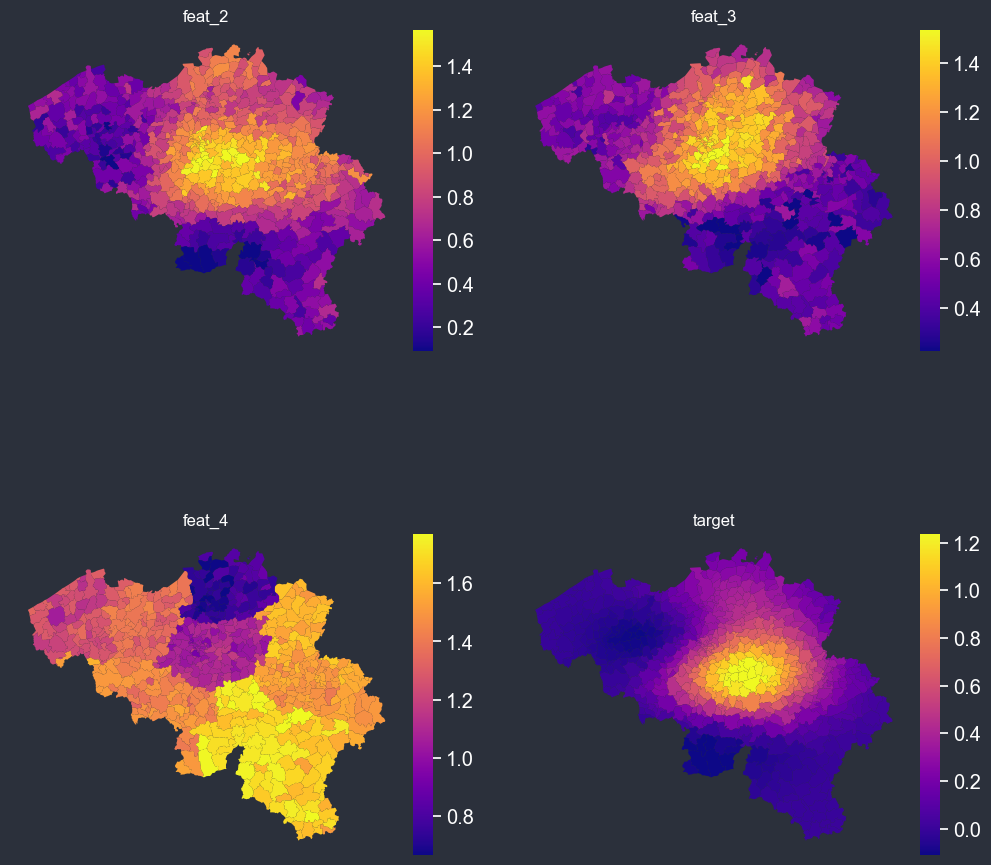

In [27]:
panel_options.autobin = False
f = spatial_average_facetplot(options=panel_options)

## Interactive background

The maps can be made interactive rather than static, using holoviews and geoviews. Run those locally to get the output.

In [ ]:
panel_options.interactive = True
panel_options.background = "StamenToner"
panel_options.autobin = False
panel_options.normalize = False
panel_options.figsize = (600, 500)
panel_options.cmap = "plasma"

f = spatial_average_facetplot(options=options)
f

In [ ]:
panel_options.interactive = True
panel_options.background = "StamenToner"
panel_options.autobin = False
panel_options.normalize = True
panel_options.figsize = (600, 500)
panel_options.cmap = "plasma"
panel_options.dissolve_on = None

f = spatial_average_facetplot(options=options)
f

In [ ]:
panel_options.autobin = True
panel_options.normalize = False
panel_options.figsize = (600, 500)
panel_options.cmap = "plasma"

f = spatial_average_facetplot(options=options)
f

In [ ]:
panel_options.dissolve_on = "borough"
f = spatial_average_facetplot(options=options)
f

In [ ]:
panel_options.autobin = True
panel_options.normalize = True
panel_options.figsize = (600, 500)
panel_options.cmap = "plasma"

f = spatial_average_facetplot(options=options)
f

## Netherlands example

In [28]:
from pathlib import Path

nl_tif = p.parents[0].joinpath("src/geomapviz/bckgd/nl_sd.tif")

shp_file = load_shp(country="NL")
geom_df = shp_file.copy()
geom_df["PC4CODE"] = geom_df["PC4CODE"].astype(str)

# create correlation with the geo entities
feat_1 = np.repeat(np.log10(geom_df["PC4CODE"].astype(int).values), 10)
feat_1 = (feat_1 - feat_1.min()) / (feat_1.max() - feat_1.min())
# dummy data
X = (
    np.repeat(geom_df.XCOORD.values, 10) - (geom_df.XCOORD.mean())
) / geom_df.XCOORD.std()
Y = (
    np.repeat(geom_df.YCOORD.values, 10) - (geom_df.YCOORD.mean())
) / geom_df.YCOORD.std()

# dummy data
nl_df = pd.DataFrame(
    {
        "geoid": np.repeat(geom_df["PC4CODE"].values, 10),
        "truth": (1 - Y + X + X * Y**3) * np.exp(-(X**2 + Y**2)),
        "feat_2": (1 - Y**3 + X**3 + Y**5) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_3": (1 + Y * X + Y**3) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_4": feat_1 + np.random.beta(5, 2, size=len(feat_1)),
        "weight": np.random.random(size=len(feat_1))
        * (1 - Y + X + Y**3)
        * np.exp(-(X**2 + Y**2)),
    }
)

nl_df = nl_df.merge(
    geom_df[["PC4CODE", "PROVC_NM", "GEMNAAM"]], left_on="geoid", right_on="PC4CODE"
)

nl_df.head()

,geoid,truth,feat_2,feat_3,feat_4,weight,PC4CODE,PROVC_NM,GEMNAAM
0,1011,0.035534,0.716181,1.486547,0.665607,0.001418,1011,Noord-Holland,Amsterdam
1,1011,0.035534,1.313496,1.245750,0.819655,0.022546,1011,Noord-Holland,Amsterdam
2,1011,0.035534,1.057813,0.931539,0.722545,0.001304,1011,Noord-Holland,Amsterdam
3,1011,0.035534,1.100774,0.657212,0.301138,0.013677,1011,Noord-Holland,Amsterdam
4,1011,0.035534,1.077853,1.269744,0.763056,0.040071,1011,Noord-Holland,Amsterdam


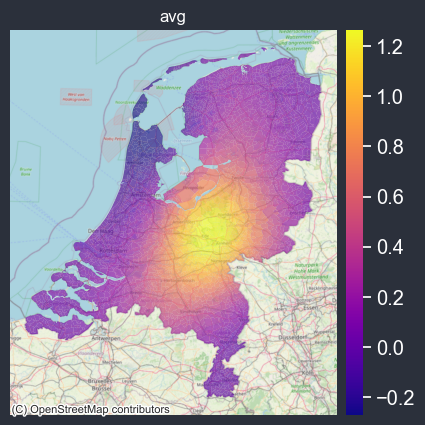

In [29]:
options = PlotOptions(
    # data arguments
    df=nl_df,
    target="truth",
    other_cols_avg=["feat_2", "feat_3", "feat_4"],
    # weights arguments
    weight=None,
    plot_weight=False,
    # geospatial arguments
    dissolve_on=None,
    geoid="PC4CODE",
    shp_file=shp_file,
    # uncertainty arguments
    distr="gaussian",
    plot_uncertainty=False,
    # style arguments
    background=cx.providers.OpenStreetMap.Mapnik,  # nl_tif,
    figsize=(5, 5),
    ncols=2,
    cmap=None,
    facecolor="#2b303b",
    nbr_of_dec=None,
    # binning arguments
    autobin=False,
    normalize=False,
    n_bins=7,
)

f = spatial_average_plot(options=options)